# Facial expression recognition 
## Aliaj, Marsela
Learning the facial expression from an image using a CNN(convolutional neural network) model.

# 1. Load Libraries

The first we do is load all the libraries we will need for this project.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import keras
from keras.models import Sequential
from keras.layers import *
from keras_preprocessing.image import ImageDataGenerator

import zipfile 

import cv2
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model

 # 2. Data

In the next cells we will see the data we are going to work with and will work on formating it. 

## 2.1 Load the Data

Our data is composed by the training set and the test set. The data consists of 28700  images of faces.  On the training set we are given the emotion it represents with the according number and the picture in the format of 48x48 pixel grayscale image. 
The test set on the other hand contains only the pixel value. Our job will be to predict what emotions they present. 

In [2]:
path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'
os.listdir(path)

['icml_face_data.csv',
 'fer2013.tar.gz',
 'example_submission.csv',
 'train.csv',
 'test.csv']

In [3]:
data = pd.read_csv(path+'icml_face_data.csv')
data.columns = ['emotion', 'Usage', 'pixels']      
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [7]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

So we see that data is the sum of all the Train set, test set (private test and public test). 

> **Helping functions**

In [8]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

def vis_training(hlist, start=1):
    
    loss = np.concatenate([h.history['loss'] for h in hlist])
    val_loss = np.concatenate([h.history['val_loss'] for h in hlist])
    acc = np.concatenate([h.history['accuracy'] for h in hlist])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in hlist])
    
    epoch_range = range(1,len(loss)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

## 2.2 Prepare the data

The task will be to categorize each of the images into one the the below categories. 

In [9]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Defining train and test data. 

In [10]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [11]:
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967,)
(5742,)


## 2.3 Display Sample of Images 

The faces have been automatically registered so that the face  is more or less centered and occupies about the same amount of space in each image. When we run the code below it presents us with different images every time. 

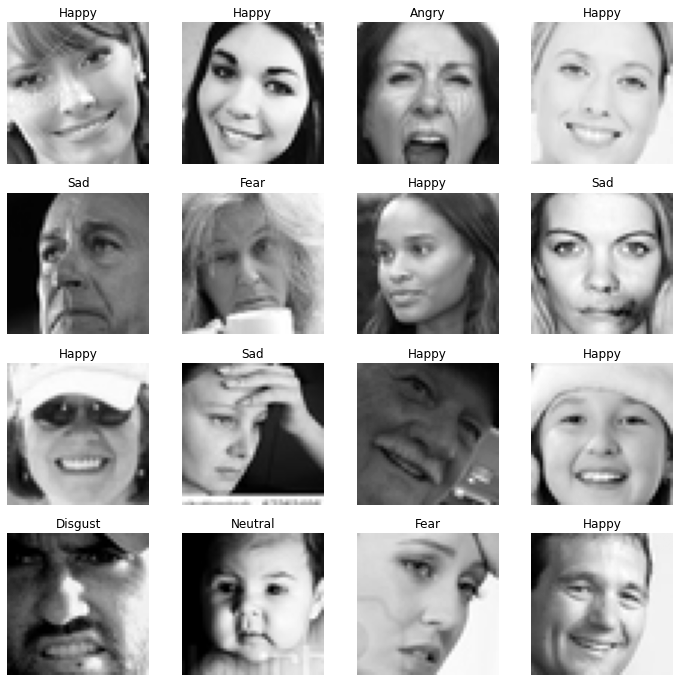

In [12]:
N_train = train_labels.shape[0]

sel = np.random.choice(range(N_train), replace=False, size=16)

X_sel = train_images[sel, :, :, :]
y_sel = train_labels[sel]

plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
    plt.title(emotions[y_sel[i]])
    plt.axis('off')
plt.show()

# 3.CNN Model

After our dataset is loaded and we have used the helping functions to clean it and formatted it, the next step is to build our model. 

In [13]:
%%time 

cnn = Sequential()

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(7, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       5

In [14]:
%%time 

opt = keras.optimizers.Adam(lr=0.001)
cnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

CPU times: user 11.8 ms, sys: 117 µs, total: 12 ms
Wall time: 12.1 ms


After we write our model, we will need to train it. Below are two training run. After each run we also include a visualization of their accuracy that helps us see how our model is doing. We notice that in the second run our accuracy is higher and overfiting gets lower. 

## 3.1 Training Run 1

In [15]:
%%time 

h1 = cnn.fit(train_images, train_labels, batch_size=256, epochs=30, verbose=1, 
                   validation_data =(valid_images, valid_labels)) 

Epoch 1/30
90/90 [==============================] - 324s 3s/step - loss: 2.1741 - accuracy: 0.1950 - val_loss: 1.8181 - val_accuracy: 0.1877
Epoch 2/30
90/90 [==============================] - 280s 3s/step - loss: 1.8677 - accuracy: 0.2278 - val_loss: 2.0583 - val_accuracy: 0.2564
Epoch 3/30
90/90 [==============================] - 280s 3s/step - loss: 1.7901 - accuracy: 0.2598 - val_loss: 2.0617 - val_accuracy: 0.2564
Epoch 4/30
90/90 [==============================] - 280s 3s/step - loss: 1.7138 - accuracy: 0.3037 - val_loss: 1.9768 - val_accuracy: 0.2562
Epoch 5/30
90/90 [==============================] - 280s 3s/step - loss: 1.6442 - accuracy: 0.3507 - val_loss: 1.6528 - val_accuracy: 0.3750
Epoch 6/30
90/90 [==============================] - 280s 3s/step - loss: 1.5450 - accuracy: 0.3880 - val_loss: 1.7058 - val_accuracy: 0.3372
Epoch 7/30
90/90 [==============================] - 280s 3s/step - loss: 1.4649 - accuracy: 0.4301 - val_loss: 1.5170 - val_accuracy: 0.4218
Epoch 8/30
90

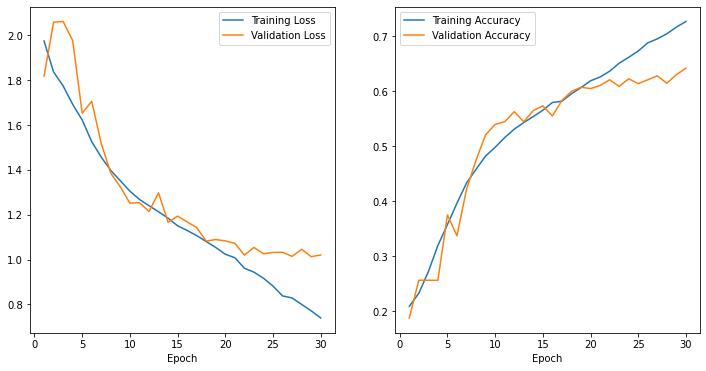

In [16]:
vis_training([h1])

## 3.2 Training Run 2

In [17]:
%%time 
keras.backend.set_value(cnn.optimizer.learning_rate, 0.00001)

h2 = cnn.fit(train_images, train_labels, batch_size=256, epochs=30, verbose=1, 
                   validation_data =(valid_images, valid_labels)) 

Epoch 1/30
90/90 [==============================] - 280s 3s/step - loss: 0.6773 - accuracy: 0.7518 - val_loss: 0.9787 - val_accuracy: 0.6503
Epoch 2/30
90/90 [==============================] - 280s 3s/step - loss: 0.6633 - accuracy: 0.7552 - val_loss: 0.9740 - val_accuracy: 0.6513
Epoch 3/30
90/90 [==============================] - 280s 3s/step - loss: 0.6553 - accuracy: 0.7622 - val_loss: 0.9732 - val_accuracy: 0.6529
Epoch 4/30
90/90 [==============================] - 280s 3s/step - loss: 0.6501 - accuracy: 0.7618 - val_loss: 0.9737 - val_accuracy: 0.6526
Epoch 5/30
90/90 [==============================] - 280s 3s/step - loss: 0.6439 - accuracy: 0.7641 - val_loss: 0.9746 - val_accuracy: 0.6512
Epoch 6/30
90/90 [==============================] - 280s 3s/step - loss: 0.6335 - accuracy: 0.7679 - val_loss: 0.9752 - val_accuracy: 0.6506
Epoch 7/30
90/90 [==============================] - 280s 3s/step - loss: 0.6340 - accuracy: 0.7689 - val_loss: 0.9750 - val_accuracy: 0.6505
Epoch 8/30
90

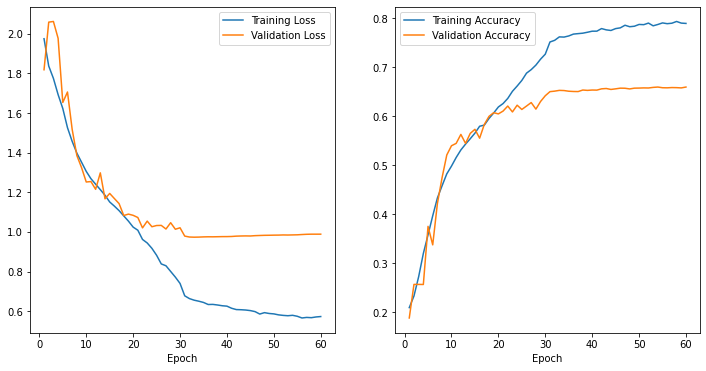

In [18]:
vis_training([h1, h2])

## 3.3 Save Model

We save our model so that it will be easier for us to access it if we need it.

In [19]:
cnn.save('final_model.h5')

# 4. Evaluating the model 

## 4.1 - Generate Test Predictions and Calculating Accuracy

Now that our model is build and trained we will generate test prediction. 
We see that our best accuracy is 0.66 or 66%. 

In [20]:
test_prob = cnn.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_labels)

print(test_accuracy)

0.6497631652270828


## 4.2 Confusion matrix

This is the first way we will use to evaluate our model. The confusion matrix is a table where every column represents teh predicted label and the rows represent the true label. 

In [21]:
conf_mat = confusion_matrix(test_labels, test_pred)

pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,534,12,81,45,154,19,113
Disgust,33,58,4,3,10,2,1
Fear,119,5,396,45,251,90,118
Happy,44,1,21,1522,58,32,96
Sad,109,3,112,71,703,20,229
Surprise,12,2,72,45,17,654,29
Neutral,73,0,42,90,213,18,797


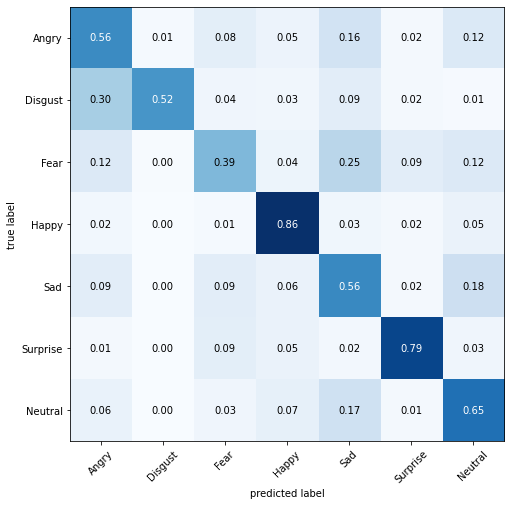

In [22]:
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

## 4.2 Classification report 

In [23]:
print(classification_report(test_labels, test_pred, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.58      0.56      0.57       958
     Disgust       0.72      0.52      0.60       111
        Fear       0.54      0.39      0.45      1024
       Happy       0.84      0.86      0.85      1774
         Sad       0.50      0.56      0.53      1247
    Surprise       0.78      0.79      0.79       831
     Neutral       0.58      0.65      0.61      1233

    accuracy                           0.65      7178
   macro avg       0.65      0.62      0.63      7178
weighted avg       0.65      0.65      0.65      7178



## 4.3 Class Activation Maps

The second method we use to evaluate our model is the class activation map. This is a simple technique that shows the image region used by the CNN to identify the specific class. In this case the region is shown in a red color to highlight the area the model used ot predict the feeling. 

In [24]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

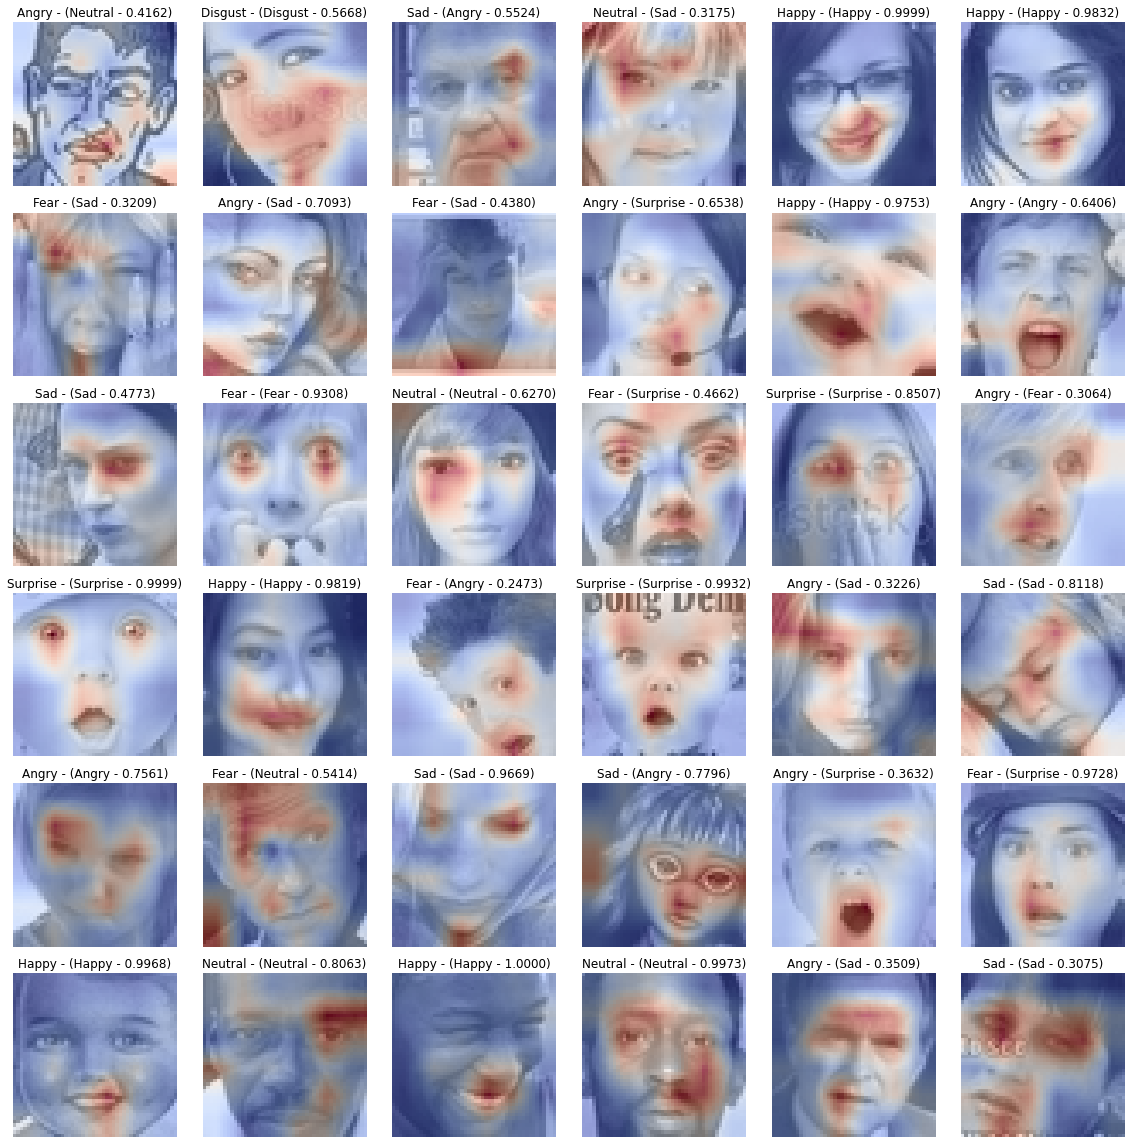

In [25]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = test_images[i,:,:,0]
    p_dist = cnn.predict(img.reshape(1,48,48,1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(cnn, k)
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))

    plt.subplot(6,6,i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{emotions[test_labels[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

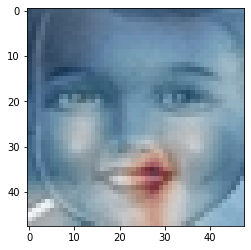

In [27]:
n = 30
img = test_images[n,:,:,0]
cam = GradCAM(cnn, 3)
heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
plt.imshow(img, cmap='binary_r')
plt.imshow(heatmap, alpha=0.5, cmap='RdBu_r')
plt.show()

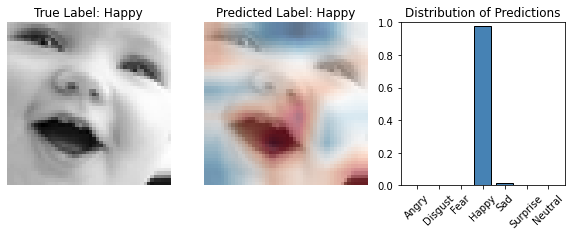

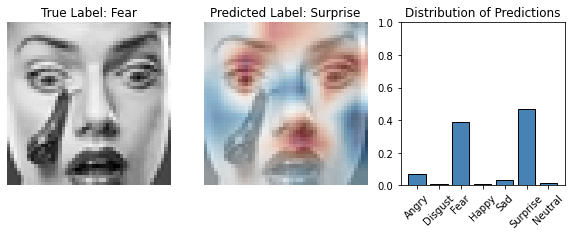

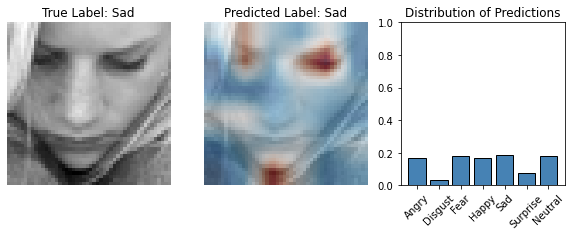

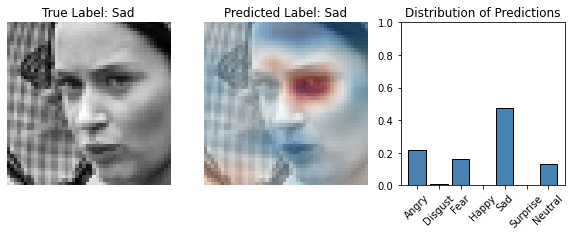

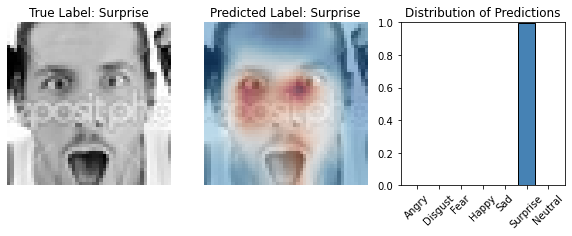

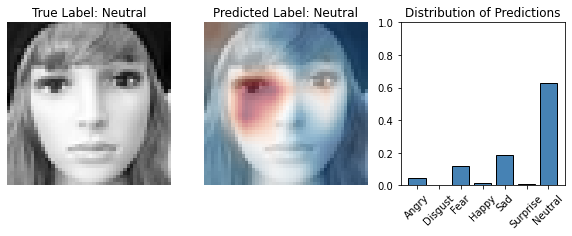

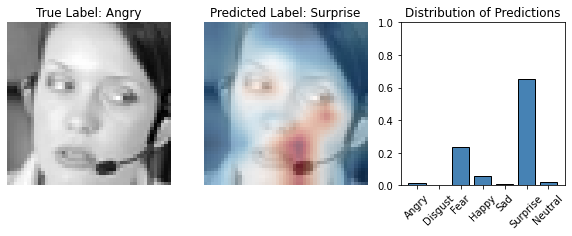

In [28]:
test_prob = cnn.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)

sel_imgs = [10, 15, 26, 12, 64, 14, 9]

for n in sel_imgs:
    img = test_images[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[test_labels[n]]}')
    plt.axis('off')
    
    cam = GradCAM(cnn, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='RdBu_r')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='steelblue', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

## 4.4 Top "K" accuracy

This metric computes the number of times where the correct label is among the top k labels predicted (ranked by predicted scores). So by Top 0 accuracy we understand how many times the model was succesful in predicting the right label in the first try. Top 1 accuracy shows us the number of times the correct label was  one of the two predection the model made, end so on. 

In [29]:
ranked_pred = np.argsort(test_prob, axis=1)
for k in range(7):
    correct = test_labels.reshape(-1,1) == ranked_pred[:, -(k+1):]
    top_k_acc = np.sum(correct) / len(test_labels)
    print(f'Top {k} Accuracy: {top_k_acc}')

Top 0 Accuracy: 0.651992198383951
Top 1 Accuracy: 0.8172192811368069
Top 2 Accuracy: 0.9061019782669267
Top 3 Accuracy: 0.959738088604068
Top 4 Accuracy: 0.986765115631095
Top 5 Accuracy: 0.9970743939816105
Top 6 Accuracy: 1.0
